<a href="https://colab.research.google.com/github/antocommi/provagcp/blob/master/ProgettoAIV_finale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Progetto Analisi di Immagini e Video - Activity Recognition
===

Required modules
---
Abbiamo bisogno di aggiornare la versione della libreria albumentations per effettuare data augmentation sui dati video.

There's need to update the library "albumentation" in order to do data augmentation on input videos.

In [1]:
!pip install -q -U albumentations # RESTART RUNTIME TO UPDATE ALBUMENTATIONS

Dependencies
-----

In [2]:
SEED = 9126

import os, cv2, json, time, math, sys, pickle, collections, PIL
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

import albumentations as A
from PIL import Image
import pandas as pd
import numpy as np
np.random.seed(SEED)
import seaborn as sn

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold

from google.colab import drive
drive.mount('/content/drive')

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
USE_CUDA = True
CUDA = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
if CUDA:
    print('run on %s' % device)

Mounted at /content/drive
run on cuda


Importing dataset from Kaggle and divide into train, validation and test set
====

Dopo aver caricato il nostro dataset su Kaggle, lo scarichiamo per rendere più veloci le operazioni di utilizzo file rispetto l'uso di Google Drive.

We can speed-up I/O operations downloading dataset from Kaggle and using it on Colab disk instead of retrieve data from Google Drive that's slower.

In [ ]:
ROOT_DIR = "/content/kaggle/"
VIDEO_DIR = "/content/kaggle/examples/"
ANNOTATION_FILE = "annotation_dict.json"
TEST_SET_FILE = "testset_keys_1lug2020.txt"

In [3]:
# Download and load in Colab disk dataset from kaggle
!mkdir ~/.kaggle # create the .kaggle folder in your root directory
!echo '{"username":"antocommii","key":"87dcebd7c4cb4ba4539ed72f027fcbde"}' > ~/.kaggle/kaggle.json # write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!kaggle datasets download --unzip --force antocommii/spacejam-action-recognition -p /content/kaggle/

 97% 665M/682M [00:18<00:00, 43.8MB/s]
100% 682M/682M [00:18<00:00, 38.2MB/s]


In [4]:
# from annotation file we retrieve labelled videos
with open(os.path.join(ROOT_DIR, ANNOTATION_FILE)) as fp:
  annotations = json.load(fp)
            
# from test file we retrieve videos who make the test set
with open(os.path.join(ROOT_DIR, TEST_SET_FILE)) as fp:
  keys_test = json.load(fp)

# creating test set and separating test and train videos
annotationTrain = dict(filter(lambda x: x[0] not in keys_test, annotations.items()))
annotationTest = dict(filter(lambda x: x[0] in keys_test, annotations.items()))
test_set = list(annotationTest.items())

# Dividing not in test videos into train set and validation set according to 90:10 split ratio and stratification to reproduce the same distribution of labels   
test_size = 0.1
train_set, valid_set = train_test_split(list(annotationTrain.items()), random_state=456, test_size=test_size, stratify=list(annotationTrain.values()))

Custom Dataset Class 
====
Abbiamo creato una classe per la gestione del nostro data secondo le linee guida di Pytorch per utilizzare in maniera efficiente le risorse durante le fasi di training e di inference.

We create a custom class to handle video dataset according to Pytorch guide and to use efficently Colab resources in training and inference phases. 

In [5]:
class CustomSet(torch.utils.data.Dataset):
    def __init__(self, videos_dir, list_dataset, transform):
        """ Construct an indexed list of video paths and labels """
        self.transform = transform
        self.VIDEO_DIR = videos_dir
        self.dataset = list_dataset
        # pytorch zoo & moabitcoin 
        #mean = [0.43216, 0.394666, 0.37645]
        #std = [0.22803, 0.22145, 0.216989]
        # # kinetics
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        self.toTensor = transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean, std)
        ])

    def __getitem__(self, index, is_for_testing=True):
        """ Load video n in the list of image paths and return it along with its label.
            In the case of multiclass the label will probably be a list of values"""
        
        name, label = self.dataset[index]
        
        fname = os.path.join(self.VIDEO_DIR, name+'.mp4')
        
        video = []
        vid = cv2.VideoCapture(fname)
        first = True
        while True:
            # Capture frame-by-frame
            ret, frame = vid.read()
            if ret != True:
              break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if first:
              data = self.transform(image=np.array(frame))
              frame = data['image']
              replay = data['replay']
              first = False
            else: 
              frame = A.ReplayCompose.replay(replay, image=np.array(frame))['image']

            frame = self.toTensor(Image.fromarray(frame))
            video.append(frame)

        video = torch.stack(video)
        video = torch.transpose(video, 1, 0)
        return {'video':video, 'label':torch.LongTensor([label])}
        

    def __len__(self):
        """ return the total number of video in this dataset """
        return len(self.dataset)

    def get_list(self):
      return self.dataset

Training, Validation and Test Loader creation
====
Per rendere utilizzabili i dati abbiamo definito i DataLoader e le trasformazioni di albumentations da effettuare per rendere i video adatti alla rete neurale utilizzata.Tra le trasformazioni aggiungiamo, per il train set solo, alcune operazioni di data augmentation per modificare alcuni video.

In order to feed videos into deep learning solution, here we have DataLoader creation and declaration of transformation using albumentations. To do data augmentation, we inizialize some transformations which we are going to use only in train set. 

In [7]:
crop_H, crop_W = 150,120
new_H, new_W = 112,112
print("New Size: ",new_H,new_W)
print("Crop Size: ",crop_H, crop_W)

A_train = A.ReplayCompose([
                     #A.augmentations.Resize(new_H, new_H, p=1),
                     A.HorizontalFlip(p=0.5),
                     A.ShiftScaleRotate(scale_limit=(0,.4), rotate_limit=0.2,p=0.5),
                     A.augmentations.transforms.CLAHE(clip_limit=4.0, p=.5),
                     A.augmentations.transforms.CenterCrop(crop_H, crop_W, p=1),
                     ])

A_test = A.ReplayCompose([
                     A.augmentations.transforms.CenterCrop(crop_H, crop_W, p=1),
                     #A.augmentations.Resize(new_H, new_H, p=1)
                     ])


# trasformo in custom_dataset
train_ds = CustomSet(VIDEO_DIR, train_set, A_train)
valid_ds = CustomSet(VIDEO_DIR, valid_set, A_test)
test_ds = CustomSet(VIDEO_DIR, test_set, A_test)

# definisco le batch_size
BATCH_TRAIN_SIZE, BATCH_TEST_SIZE = 16,16

# creo i dataloader
trainLoader = DataLoader(train_ds, batch_size=BATCH_TRAIN_SIZE, shuffle=True, num_workers=2)
validLoader = DataLoader(valid_ds, batch_size=BATCH_TEST_SIZE, shuffle=True, num_workers=2)
testLoader = DataLoader(test_ds, batch_size=BATCH_TEST_SIZE, shuffle=True, num_workers=2)

# controllo se hanno la stessa forma di lista di tuple
print(len(trainLoader), len(validLoader), len(testLoader))
print(train_set[0])

New Size:  112 112
Crop Size:  150 120
1461 163 696
('0037660', 9)


Di seguito una estrazione di una clip separata in frame per mostrare la transformazione finale.

Here we show the result of a processed clip.

run


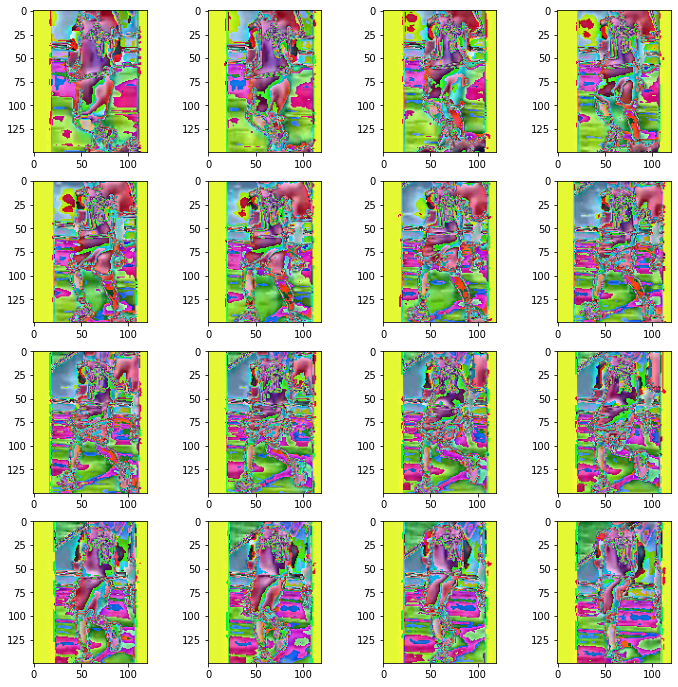

In [8]:
labels_dict = {0 : "block", 1 : "pass", 2 : "run", 3: "dribble",4: "shoot",
          5 : "ball in hand", 6 : "defense", 7: "pick" , 8 : "no_action" , 
          9: "walk" ,10: "discard"}

for item in trainLoader:
  video = item['video'][0]
  label = item['label'][0]
  break
clip = torch.transpose(video, 0, 1)

print(labels_dict[label.item()])
plt.figure(figsize=(12, 12))
for i in range(clip.shape[0]):
  plt.subplot(4,4, i+1)
  video = clip[i]
  trans = transforms.ToPILImage(mode="RGB")
  video = trans(video)
  plt.imshow(video)
plt.show()

Build S3D model
====
https://github.com/kylemin/S3D kinetics-400 weights

https://arxiv.org/pdf/1712.04851.pdf implementation

In [9]:
class S3D(nn.Module):
    def __init__(self, num_class):
        super(S3D, self).__init__()
        self.base = nn.Sequential(
            SepConv3d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool3d(kernel_size=(1,3,3), stride=(1,2,2), padding=(0,1,1)),
            BasicConv3d(64, 64, kernel_size=1, stride=1),
            SepConv3d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.MaxPool3d(kernel_size=(1,3,3), stride=(1,2,2), padding=(0,1,1)),
            Mixed_3b(),
            Mixed_3c(),
            nn.MaxPool3d(kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1)),
            Mixed_4b(),
            Mixed_4c(),
            Mixed_4d(),
            Mixed_4e(),
            Mixed_4f(),
            nn.MaxPool3d(kernel_size=(2,2,2), stride=(2,2,2), padding=(0,0,0)),
            Mixed_5b(),
            Mixed_5c(),
        )
        self.fc = nn.Sequential(nn.Conv3d(1024, num_class, kernel_size=1, stride=1, bias=True),)

    def forward(self, x):
        y = self.base(x)
        y = F.avg_pool3d(y, (2, y.size(3), y.size(4)), stride=1)
        y = self.fc(y)
        y = y.view(y.size(0), y.size(1), y.size(2))
        logits = torch.mean(y, 2)

        return logits

class BasicConv3d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv3d, self).__init__()
        self.conv = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm3d(out_planes, eps=1e-3, momentum=0.001, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class SepConv3d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(SepConv3d, self).__init__()
        self.conv_s = nn.Conv3d(in_planes, out_planes, kernel_size=(1,kernel_size,kernel_size), stride=(1,stride,stride), padding=(0,padding,padding), bias=False)
        self.bn_s = nn.BatchNorm3d(out_planes, eps=1e-3, momentum=0.001, affine=True)
        self.relu_s = nn.ReLU()

        self.conv_t = nn.Conv3d(out_planes, out_planes, kernel_size=(kernel_size,1,1), stride=(stride,1,1), padding=(padding,0,0), bias=False)
        self.bn_t = nn.BatchNorm3d(out_planes, eps=1e-3, momentum=0.001, affine=True)
        self.relu_t = nn.ReLU()

    def forward(self, x):
        x = self.conv_s(x)
        x = self.bn_s(x)
        x = self.relu_s(x)

        x = self.conv_t(x)
        x = self.bn_t(x)
        x = self.relu_t(x)
        return x

class Mixed_3b(nn.Module):
    def __init__(self):
        super(Mixed_3b, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(192, 64, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(192, 96, kernel_size=1, stride=1),
            SepConv3d(96, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(192, 16, kernel_size=1, stride=1),
            SepConv3d(16, 32, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(192, 32, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)

        return out


class Mixed_3c(nn.Module):
    def __init__(self):
        super(Mixed_3c, self).__init__()
        self.branch0 = nn.Sequential(
            BasicConv3d(256, 128, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(256, 128, kernel_size=1, stride=1),
            SepConv3d(128, 192, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(256, 32, kernel_size=1, stride=1),
            SepConv3d(32, 96, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(256, 64, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_4b(nn.Module):
    def __init__(self):
        super(Mixed_4b, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(480, 192, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(480, 96, kernel_size=1, stride=1),
            SepConv3d(96, 208, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(480, 16, kernel_size=1, stride=1),
            SepConv3d(16, 48, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(480, 64, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_4c(nn.Module):
    def __init__(self):
        super(Mixed_4c, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(512, 160, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(512, 112, kernel_size=1, stride=1),
            SepConv3d(112, 224, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(512, 24, kernel_size=1, stride=1),
            SepConv3d(24, 64, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(512, 64, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_4d(nn.Module):
    def __init__(self):
        super(Mixed_4d, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(512, 128, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(512, 128, kernel_size=1, stride=1),
            SepConv3d(128, 256, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(512, 24, kernel_size=1, stride=1),
            SepConv3d(24, 64, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(512, 64, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_4e(nn.Module):
    def __init__(self):
        super(Mixed_4e, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(512, 112, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(512, 144, kernel_size=1, stride=1),
            SepConv3d(144, 288, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(512, 32, kernel_size=1, stride=1),
            SepConv3d(32, 64, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(512, 64, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_4f(nn.Module):
    def __init__(self):
        super(Mixed_4f, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(528, 256, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(528, 160, kernel_size=1, stride=1),
            SepConv3d(160, 320, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(528, 32, kernel_size=1, stride=1),
            SepConv3d(32, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(528, 128, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_5b(nn.Module):
    def __init__(self):
        super(Mixed_5b, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(832, 256, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(832, 160, kernel_size=1, stride=1),
            SepConv3d(160, 320, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(832, 32, kernel_size=1, stride=1),
            SepConv3d(32, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(832, 128, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_5c(nn.Module):
    def __init__(self):
        super(Mixed_5c, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(832, 384, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(832, 192, kernel_size=1, stride=1),
            SepConv3d(192, 384, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(832, 48, kernel_size=1, stride=1),
            SepConv3d(48, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(832, 128, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out

model = S3D(num_class=400)

state_dict = torch.hub.load_state_dict_from_url(url="https://drive.google.com/uc?export=download&id=1HJVDBOQpnTMDVUM3SsXLy0HUkf_wryGO")
new_state_dict = collections.OrderedDict()
for k,v in state_dict.items():
  name = k[7:] # tolgo il module. dalla key
  new_state_dict[name] = v
model.load_state_dict(new_state_dict)

model.fc = nn.Sequential(nn.Conv3d(1024, 10, kernel_size=1, stride=1, bias=True),)

Downloading: "https://drive.google.com/uc?export=download&id=1HJVDBOQpnTMDVUM3SsXLy0HUkf_wryGO" to /root/.cache/torch/hub/checkpoints/uc


Training and evalutation methods
====
Descriviamo qui i metodi di training di una singola epoca e di un intero passo di validation.

Below in the cell there are training method for just an epoch and inference method ('evaluate') used both in validation and testing phases.

In [10]:
def train_one_epoch(model, optimizer, trainloader, epoch, num_epochs):
  # define epoch measures
  model.train()
  running_loss = 0.0
  train_correct = 0
  # for each batch in train set
  for batch_i,item in enumerate(trainloader):
    video, target = item['video'], item['label'] # extract video and label tensors
    target = torch.reshape(target, (-1,))
    video, target = video.to(device), target.to(device) # put them into cuda gpu
    # make train and backpropagation + update weights
    optimizer.zero_grad()
    outputs = model(video)
    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()
    # define current measures
    _, predicted = torch.max(outputs.data, 1)
    correct_lbls = (predicted == target).sum().item()
    train_correct = train_correct + correct_lbls
    running_loss = running_loss + loss.item()
    # Print log
    sys.stdout.write(
      "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)] [lr: %.7f%%]"
      % (
        epoch+1,
        num_epochs,
        batch_i,
        len(trainloader),
        loss.item(),
        running_loss/(1+batch_i),
        100*(correct_lbls/float(BATCH_TRAIN_SIZE)),
        100*(train_correct/float(BATCH_TRAIN_SIZE*(1+batch_i))),
        optimizer.param_groups[0]['lr']
      )
    )


  return [running_loss, train_correct]


def evaluate(model, validloader, isTestingPhase):
  model.eval()
  running_loss = 0.0
  valid_correct = 0
  if isTestingPhase:
    predicts, labels = [],[]
  
  with torch.no_grad():
    for item in validloader:
      video, target = item['video'], item['label']
      target = torch.reshape(target, (-1,))
      video, target = video.to(device), target.to(device)
      # feed video into model to obtain labels and calculate loss value
      outputs = model(video)
      val_loss = criterion(outputs, target)
      
      # monitoring loss and accuracy scores      
      _, predicted = torch.max(outputs.data, 1)
      valid_correct = valid_correct + (predicted == target).sum().item()
      running_loss += val_loss.item()

      if isTestingPhase:
        predicts.append(predicted.data)
        labels.append(target.data)

  if isTestingPhase:
    return [(predicts, labels), running_loss, valid_correct]
  
  else:
    return [None, running_loss, valid_correct]

Definiamo quindi la strategia di training:
    
    1 svuoto la cache prima di iniziare
    2 definisco ottimizzatore e learning rate scheduler
    3 definisco la loss come CrossEntropy per classificazione multiclasse
    4 nel caso in cui io debba riprendere un'esecuzione imposto 'restore' a valore True
    5 per ogni epoca faccio in sequenza: addestramento, validazione e aggiorno il learning rate scheduler

Here we have training strategy:

    1 empty cuda memory before starting 
    2 inizialize model optimizer and learning rate scheduler
    3 use CrossEntropy as loss to match our multiclass classification task 
    4 turn 'restore' variable to True if we need to start from a specified epoch the learning process
    5 for each epoch: train the model, validate it and update learning rate scheduler 

In [ ]:
# SVUOTO LA CACHE
torch.cuda.empty_cache()

# COSTRUISCO OPTIMIZER: learning rate, optimizer e scheluder lr 
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # classico
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, min_lr=1e-6) # varia lr su plateau

# COSTRUISCO CRITERIO DI LOSS: pesi per ds sbilanciato e criterion
y_train = [v for k,v in train_set]
weights = torch.FloatTensor(compute_class_weight('balanced', np.unique(y_train), y_train )).cuda()
criterion = nn.CrossEntropyLoss()

# DEFINISCO PARAMETRI DI TRAINING E VALIDATION
starting_epoch = 0 # numero epoca di partenza
EPOCHS=70
tr_loss, val_loss = [], []
tr_accs, val_accs = [], []

# RECUPERO EPOCHE SALVATE
restore = False
if(restore):
  checkpoint_init = torch.load('drive/MyDrive/Copia di _SlowFast_SGD_lr0.001_e12_1614555421.pth')
  starting_epoch = checkpoint_init['epoch'] + 1 
  model.load_state_dict(checkpoint_init['model_state_dict'])
  optimizer.load_state_dict(checkpoint_init['optimizer_state_dict'])
  criterion = checkpoint_init['loss']
  lr_scheduler.load_state_dict(checkpoint_init['scheduler'])
  tr_loss, val_loss = checkpoint_init['losses']
  tr_accs, val_accs = checkpoint_init['accs']

print()
print("val_set_size: " + str(test_size), end =" + ")
print(str(new_W)+"x"+str(new_H), end =" + ")
print(model.__class__.__name__, end =" + ")
print(optimizer.param_groups[0]['lr'], end =" + ")
print(optimizer.__class__.__name__, end =" + ")
print(lr_scheduler.__class__.__name__, end =" + ")
print(criterion.__class__.__name__)
if not restore: 
  print(" + " + "from scratch!")
else:
  print(" + " + "not from scratch!")

# INIZIO ADDESTRAMENTO
model = model.to(device)
for epoch in range(starting_epoch, EPOCHS):
  # TRAIN FOR ONE EPOCH
  start_time = time.time()
  train_loss, train_correct = train_one_epoch(model, optimizer, trainLoader, epoch, EPOCHS)
  
  # VALIDATE RESULT
  _, valid_loss, valid_correct = evaluate(model, validLoader, isTestingPhase=False)

  # STEP TO APPLY LEARNING SCHEDULER
  #lr_scheduler.step() 
  lr_scheduler.step( valid_loss/float(len(validLoader)) )

  print(
      f' [Val_loss = {valid_loss/float(len(validLoader)):0.7f},'
      f' Val_acc = {100*valid_correct/float(len(validLoader)*BATCH_TEST_SIZE):0.7f}]',
      f'in {time.time()-start_time:.2f} sec'
  )

  tr_loss.append(train_loss/float(len(trainLoader)))
  val_loss.append(valid_loss/float(len(validLoader)))
  tr_accs.append(float(train_correct)/float(len(trainLoader)*BATCH_TRAIN_SIZE))
  val_accs.append(float(valid_correct)/float(len(validLoader)*BATCH_TEST_SIZE))

  checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            'scheduler':lr_scheduler.state_dict(),
            'losses': (tr_loss, val_loss),
            'accs': (tr_accs, val_accs)
  }

  path="drive/MyDrive/"
  lr_ = optimizer.param_groups[0]['lr']
  t = str(round(time.time()))
  torch.save(checkpoint, path+'_'+model.__class__.__name__+'_'+optimizer.__class__.__name__+'_lr'+str(lr_)+'_e'+str(epoch)+'_'+t+'.pth')
  print(t,end="")


val_set_size: 0.1 + 112x112 + S3D + 0.001 + Adam + ReduceLROnPlateau + CrossEntropyLoss
 + from scratch!
[Epoch 1/70] [Batch 1460/1461] [Loss: 1.168012 (0.992336), Acc: 12.50% (65.31%)] [lr: 0.0010000%] [Val_loss = 0.7784437, Val_acc = 72.8527607] in 910.89 sec
[Epoch 2/70] [Batch 1460/1461] [Loss: 0.616964 (0.723360), Acc: 12.50% (74.18%)] [lr: 0.0010000%] [Val_loss = 0.7822465, Val_acc = 72.9677914] in 918.12 sec
[Epoch 3/70] [Batch 1460/1461] [Loss: 0.315076 (0.604863), Acc: 12.50% (77.84%)] [lr: 0.0010000%] [Val_loss = 0.6521575, Val_acc = 78.3358896] in 916.44 sec
[Epoch 4/70] [Batch 1460/1461] [Loss: 0.461044 (0.509826), Acc: 12.50% (81.40%)] [lr: 0.0010000%] [Val_loss = 0.5970728, Val_acc = 79.0644172] in 911.96 sec
[Epoch 5/70] [Batch 1460/1461] [Loss: 1.243296 (0.447791), Acc: 6.25% (83.49%)] [lr: 0.0010000%] [Val_loss = 0.6773231, Val_acc = 77.3006135] in 913.93 sec
[Epoch 6/70] [Batch 1460/1461] [Loss: 0.140474 (0.393116), Acc: 18.75% (85.19%)] [lr: 0.0010000%] [Val_loss = 

Testing phase
===
Una volta interrotta la fase di training a causa di un plateau nel valore di acccuracy, procediamo con la fase di testing sul nostro test set predefinito.

Since we stopped training phase beacause of plateau in accuracy score, we do inference according to our predefined test set.

In [ ]:
pathWeights = './dump_S3D_and_weightE20_final_AIM.pth' # if dump file on disk

In [ ]:
pathWeights = 'kaggle/dump_S3D_and_weightE20_final_AIM.pth' 

In [15]:
model = S3D(num_class=10) # create the model
checkpoint_init = torch.load(pathWeights) # retrieve weights from disk
model.load_state_dict(checkpoint_init['weights']) # load weights into new S3D model with chosen epoch
model = model.to(device) # move to cuda

In [16]:
criterion  = nn.CrossEntropyLoss() # define loss 
outputTargetTuple, test_loss, test_correct = evaluate(model, testLoader, isTestingPhase=True)
y_pred, y_true = torch.cat(outputTargetTuple[0]).cpu().detach().numpy(), torch.cat(outputTargetTuple[1]).cpu().detach().numpy() 
print(f'Accuracy = {(test_correct/float(len(testLoader)*BATCH_TEST_SIZE))*100}%')
print(classification_report(y_true=y_true, y_pred=y_pred, zero_division=0))

Accuracy = 83.7194683908046%
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       292
           1       0.86      0.86      0.86       318
           2       0.89      0.87      0.88      1841
           3       0.96      0.96      0.96      1068
           4       0.89      0.94      0.92       125
           5       0.90      0.90      0.90       709
           6       0.79      0.73      0.76      1178
           7       0.79      0.80      0.79       228
           8       0.80      0.77      0.78      1916
           9       0.80      0.84      0.82      3451

    accuracy                           0.84     11126
   macro avg       0.86      0.86      0.86     11126
weighted avg       0.84      0.84      0.84     11126

